# Deep Learning for Time Series

### Loading Libraries

In [1]:
# Math Computing
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.utils import load_img, img_to_array

# TensorFlow Datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import imdb
from tensorflow.keras.datasets import reuters
from tensorflow.keras.datasets import boston_housing

# Operating System
import os, shutil, pathlib
import random

### A Temperature-Forecasting example

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-18 11:57:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.196.48, 52.216.177.109, 52.217.117.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.196.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  2.44MB/s    in 10s     

2024-04-18 11:57:15 (1.26 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


##### Inspecting the data of the Jena weather dataset

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


##### Parsing The Data

In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

##### Plotting The Temperature Timeseries

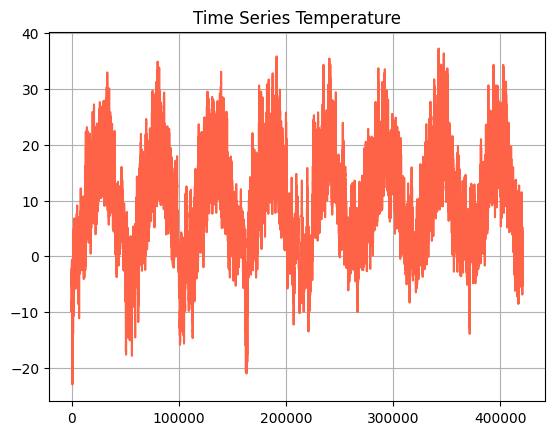

In [4]:
plt.plot(range(len(temperature)), temperature, color='tomato')
plt.title('Time Series Temperature')
plt.grid(True)
plt.show()

##### Plotting The First 10 days of the Temperature Timeseries

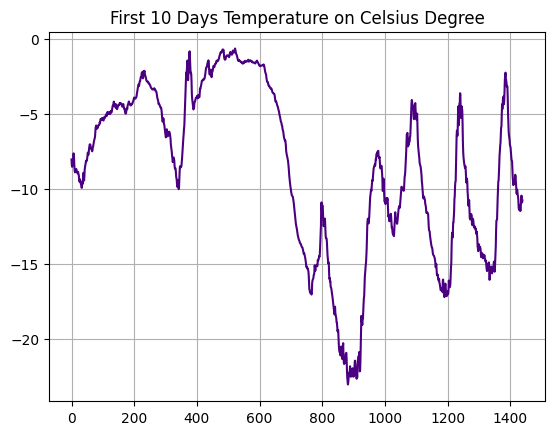

In [6]:
plt.plot(range(1440), temperature[:1440], color='indigo')
plt.title('First 10 Days Temperature on Celsius Degree')
plt.grid(True)
plt.show()

##### Computing The Number of Samples for each Data Split

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


##### Preparing The Data

In [9]:
# Training & Validation Data Mean & Standard Deviation Computing
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
# Time_series_dataset_from_array()
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


##### Instantiating Datasets for Training, Validation & Testing

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Training Set
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# Validation Set
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# Test Set
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

##### Inspecting The Output of one of our Datasets

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#### A Common-Sense, Non-Machine-Learning Baseline

##### Computing the common-sense baseline (MAE)

In [14]:
# np.mean(np.abs(preds - targets))

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.28
Test MAE: 10.40


##### Trying a Basic Machine Learning Model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 5s 6ms/step - loss: 11.8348 - mae: 2.6634 - val_loss: 10.8552 - val_mae: 2.6047
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 8.8442 - mae: 2.3399 - val_loss: 12.5908 - val_mae: 2.7876
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 8.1710 - mae: 2.2530 - val_loss: 11.0420 - val_mae: 2.6351
Epoch 4/10
819/819 [==============================] - 5s 6ms/step - loss: 7.7732 - mae: 2.1969 - val_loss: 13.2658 - val_mae: 2.9051
Epoch 5/10
819/819 [==============================] - 5s 7ms/step - loss: 7.4211 - mae: 2.1487 - val_loss: 10.5641 - val_mae: 2.5772
Epoch 6/10
819/819 [==============================] - 5s 6ms/step - loss: 7.2429 - mae: 2.1219 - val_loss: 11.9177 - val_mae: 2.7496
Epoch 7/10
819/819 [==============================] - 5s 6ms/step - loss: 7.0325 - mae: 2.0904 - val_loss: 11.1526 - val_mae: 2.6486
Epoch 8/10
819/819 [==============================] - 5s 6ms/step - 

##### Plotting results

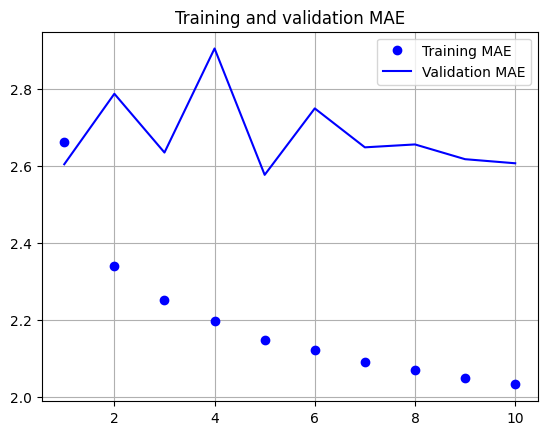

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.grid(True)
plt.show()

##### Trying a 1D Convolutional Model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 10ms/step - loss: 23.3853 - mae: 3.7888 - val_loss: 18.2539 - val_mae: 3.3954
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 15.5935 - mae: 3.1415 - val_loss: 16.6273 - val_mae: 3.2064
Epoch 3/10
819/819 [==============================] - 9s 10ms/step - loss: 14.2104 - mae: 2.9943 - val_loss: 15.7616 - val_mae: 3.1547
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 13.4275 - mae: 2.9048 - val_loss: 13.7382 - val_mae: 2.9234
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 12.8985 - mae: 2.8436 - val_loss: 17.1334 - val_mae: 3.2485
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 12.5138 - mae: 2.7997 - val_loss: 14.3292 - val_mae: 2.9938
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 12.1402 - mae: 2.7569 - val_loss: 15.4165 - val_mae: 3.0474
Epoch 8/10
819/819 [==============================] - 8

#### A First Recurrent Baseline

##### A Simple LSTM-based Model

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 21ms/step - loss: 45.7738 - mae: 4.9590 - val_loss: 13.8589 - val_mae: 2.8135
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 11.2428 - mae: 2.6031 - val_loss: 9.9583 - val_mae: 2.4512
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 9.8794 - mae: 2.4573 - val_loss: 9.8767 - val_mae: 2.4328
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 9.4547 - mae: 2.4016 - val_loss: 9.8750 - val_mae: 2.4352
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 9.1897 - mae: 2.3641 - val_loss: 10.0773 - val_mae: 2.4576
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 9.0230 - mae: 2.3394 - val_loss: 10.1971 - val_mae: 2.4708
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 8.8883 - mae: 2.3179 - val_loss: 10.2106 - val_mae: 2.4682
Epoch 8/10
819/819 [==============================] - 18

### Understanding Recurrent Neural Networks

##### NumPy implementation of a simple RNN

In [21]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

#### A Recurrent Layer in Keras

##### An RNN layer that can process sequences of any length

In [22]:
num_features = 14

inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [23]:
print(outputs.shape)

(None, 16)


##### An RNN Layer that returns only its last output step

In [24]:
num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


##### An RNN Layer that returns its full output sequence

In [25]:
num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


##### Stacking RNN Layers

In [26]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

### Advanced use of Recurrent Neural Networks (RNN)

#### Using recurrent dropout to fight overfitting

##### Training and evaluating a dropout-regularized LSTM

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 47s 57ms/step - loss: 29.3182 - mae: 3.9759 - val_loss: 9.8619 - val_mae: 2.4190
Epoch 2/50
819/819 [==============================] - 48s 59ms/step - loss: 14.6854 - mae: 2.9744 - val_loss: 9.3907 - val_mae: 2.3652
Epoch 3/50
819/819 [==============================] - 48s 59ms/step - loss: 13.7393 - mae: 2.8727 - val_loss: 9.2967 - val_mae: 2.3679
Epoch 4/50
819/819 [==============================] - 49s 59ms/step - loss: 13.1140 - mae: 2.8095 - val_loss: 9.3162 - val_mae: 2.3686
Epoch 5/50
819/819 [==============================] - 49s 59ms/step - loss: 12.6760 - mae: 2.7637 - val_loss: 9.1523 - val_mae: 2.3542
Epoch 6/50
819/819 [==============================] - 49s 59ms/step - loss: 12.2847 - mae: 2.7208 - val_loss: 9.3375 - val_mae: 2.3847
Epoch 7/50
819/819 [==============================] - 49s 60ms/step - loss: 11.9572 - mae: 2.6840 - val_loss: 9.5185 - val_mae: 2.4060
Epoch 8/50
819/819 [==============================] - 5

In [28]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

#### Stacking Recurrent Layers

##### Training and Evaluating a Dropout-regularized, stacked GRU model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 88s 106ms/step - loss: 24.1665 - mae: 3.6439 - val_loss: 9.2607 - val_mae: 2.3538
Epoch 2/50
819/819 [==============================] - 88s 107ms/step - loss: 13.8577 - mae: 2.8835 - val_loss: 9.4948 - val_mae: 2.4003
Epoch 3/50
819/819 [==============================] - 87s 106ms/step - loss: 13.0718 - mae: 2.8020 - val_loss: 9.1371 - val_mae: 2.3513
Epoch 4/50
819/819 [==============================] - 87s 107ms/step - loss: 12.4967 - mae: 2.7431 - val_loss: 8.6955 - val_mae: 2.2922
Epoch 5/50
819/819 [==============================] - 87s 106ms/step - loss: 12.0649 - mae: 2.6946 - val_loss: 8.8550 - val_mae: 2.3183
Epoch 6/50
819/819 [==============================] - 87s 107ms/step - loss: 11.5799 - mae: 2.6404 - val_loss: 8.9640 - val_mae: 2.3249
Epoch 7/50
819/819 [==============================] - 87s 107ms/step - loss: 11.2955 - mae: 2.6056 - val_loss: 9.0848 - val_mae: 2.3463
Epoch 8/50
819/819 [============================

#### Using Bidirectional RNNs

##### Training and Evaluating a Bidirectional LSTM

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 22s 26ms/step - loss: 26.6642 - mae: 3.7158 - val_loss: 10.7984 - val_mae: 2.5480
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 9.4296 - mae: 2.4011 - val_loss: 9.9776 - val_mae: 2.4524
Epoch 3/10
819/819 [==============================] - 22s 27ms/step - loss: 8.4778 - mae: 2.2724 - val_loss: 10.2565 - val_mae: 2.4884
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 7.9673 - mae: 2.2022 - val_loss: 10.1736 - val_mae: 2.4663
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 7.5488 - mae: 2.1473 - val_loss: 10.2467 - val_mae: 2.4787
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 7.2488 - mae: 2.1045 - val_loss: 10.0650 - val_mae: 2.4568
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 7.0122 - mae: 2.0689 - val_loss: 9.8027 - val_mae: 2.4231
Epoch 8/10
819/819 [==============================] - 22